In [1]:
!pip install --upgrade pip
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

In [3]:
# Fuente: https://www.kaggle.com/datasets/adityaramachandran27/nasa-near-earth-objects-information

In [4]:
df_raw = pd.read_csv('../data/2/NASA Near-Earth Objects.csv')

### Objetivos de estudio

- Analizar el dataset, buscar correlaciones entre variables y transformar datos
- Evaluar como solucionar la problematica de que el dataset es desbalanceado en la columna target de interes
- Aplicar algoritmos de clasificacion para determinar si un NEO tiene peligro potencial de impacto
- Aplicar tecnicas de optimizacion de la performance del algoritmo

### Diccionario de datos:

- Unnamed: 0: Default index

- id: A unique ID given by NASA

- neo_reference_id: A unique ID given by NASA to all NEO, same as the ID

- name: Official name given by NASA

- name_limited: Normal name without the scientific notations

- designation: The number used in the official name given by NASA

- absolute_magnitude_h: Absolute magnitude (M) is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical

- is_potentially_hazardous_asteroid: Boolean value which tells if the object poses a threat to earth or not

- is_sentry_object: Boolean value which tells if the object is present in the sentry tracking system or not (Sentry: https://en.wikipedia.org/wiki/Sentry_(monitoring_system))

- kilometers_estimated_diameter_min: Minimum estimated diameter in kilometer

- kilometers_estimated_diameter_max: Maximum estimated diameter in kilometer

- orbit_id: A unique ID for the orbit of the object

- orbit_class_type: Classification of the object orbit into classes

    - (AMO is referring to Amor asteroids: near-Earth asteroids. The orbital perihelion of these objects is close to, but greater than, the orbital aphelion of Earth (a > 1.0 AU and 1.017 AU < q < 1.3 AU).

    - APO is referring to Apollo asteroids: near-Earth asteroid orbits which cross the Earth's orbit (a > 1.0 AU and q < 1.017 AU).)

    - (Abajo hay mas info sobre el tema, incluyendo las orbitas de tipo ATE e IEO)

- perihelion_distance: Has the perihelion distance (the point nearest to the Earth in the path of an orbiting celestial body)

- aphelion_distance: Has the aphelion distance (the point in the orbit of a planet, asteroid, or object at which it is furthest from the Earth)

- first_observation_date: Date when the object was first observed

- last_observation_date: Date when the object was last observed

- orbit_class_description: The description of the orbit

Asteroids are dynamically classified as "Near-Earth" if their perihelion distance is less than 1.3 AU. They are further divided into groups based on their semi-major axis (a), perihelion distance (q), and aphelion distance (Q).

- Apollos (APO) cross Earth's orbit and have a semi-major axis of more than 1 AU
- Amors (AMO) have orbits strictly outside Earth's orbit
- Atens (ATE) cross Earth's orbit and have a semi-major axis of less than 1 AU
- Atiras (IEO) have orbits strictly inside Earth's orbit

(Fuente: https://www.comet-toolbox.com/neos.html)

In [5]:
# Aqui leemos la informacion general de los datos, vemos la dimension total, la cantidad de datos no nulos y el tipo de dato por columna

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

Observar que hay datos faltantes en columnas como 'absolute_magnitude_h ' y 'name_limited'. En el segundo caso es porque NASA no le asigna nombres propios a todos los cuerpos

In [6]:
# Se elimina la columna 'Unnamed: 0' ya que son los indices de las filas, y al importar los datos, pandas ya me los define
 
df_raw.drop(columns = ['Unnamed: 0'], inplace = True)

In [7]:
# Descripicion de variables numericas

df_raw.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


In [8]:
# Descripicion de variables categoricas (object, bool, en este caso)

df_raw.describe(include = ['object','bool'])

,name,name_limited,designation,is_potentially_hazardous_asteroid,is_sentry_object,orbit_id,orbit_class_type,first_observation_date,last_observation_date,orbit_class_description
count,24000,144,24000,24000,24000,24000,24000,24000,24000,24000
unique,24000,144,24000,2,2,352,4,5964,5016,4
top,1981 Midas (1973 EA),Midas,1981,False,False,7,APO,2014-04-23,2022-04-15,Near-Earth asteroid orbits which cross the Ear...
freq,1,1,1,21906,22934,1485,13245,67,40,13245


Podemos ver que la asignacion de nombres por parte de la NASA es unica, ya que en las columnas 'name', 'name_limited' y 'designation' tenemos todos valores unicos. Vamos a chequear tambien en la columna 'id' si se cumple

In [9]:
df_raw['id'].duplicated().any()

False

In [10]:
# Muestra de los datos

df_raw.sample(5)

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
23026,54017626,54017626,(2020 MT2),NaN,2020 MT2,24.0,False,False,0.042126,0.094198,9,AMO,1.052910,1.724193,2020-05-30,2020-07-12,Near-Earth asteroid orbits similar to that of ...
5269,3367720,3367720,(2007 CR5),NaN,2007 CR5,25.4,False,False,0.022108,0.049436,9,APO,0.898089,2.338562,2007-02-08,2007-02-15,Near-Earth asteroid orbits which cross the Ear...
10536,3655548,3655548,(2013 YA38),NaN,2013 YA38,21.0,False,False,0.167708,0.375008,15,APO,0.747198,4.242264,2013-12-27,2021-07-07,Near-Earth asteroid orbits which cross the Ear...
18353,3825579,3825579,(2018 NO1),NaN,2018 NO1,22.2,False,False,0.096506,0.215794,19,AMO,1.237100,4.688517,2018-07-08,2018-09-20,Near-Earth asteroid orbits similar to that of ...
19422,3837853,3837853,(2019 AH11),NaN,2019 AH11,18.9,False,False,0.441118,0.986370,17,AMO,1.203913,4.043749,2019-01-11,2019-08-28,Near-Earth asteroid orbits similar to that of ...


#### Primeras observaciones

- Las columnas 'id' y 'neo_reference_id' son identicas, asi que nos podemos quedar solo con una de ellas
- La columna 'name_limited' es simplemente la extraccion del nombre propio del cuerpo (si es que lo tiene), dato que ya esta en la columna 'name', por lo que no nos presenta informacion relevante, mas alla de sacar la proporcion de cuerpos a los que la NASA le ha asignado un valor propio. 
- Algo similar sucede con la columna 'designation', la cual tambien es una parte del nombre oficial establecido, y el dato completo del nombre esta en la columna 'name'

In [11]:
df_raw.drop(columns = ['neo_reference_id', 'name_limited', 'designation'], inplace = True)

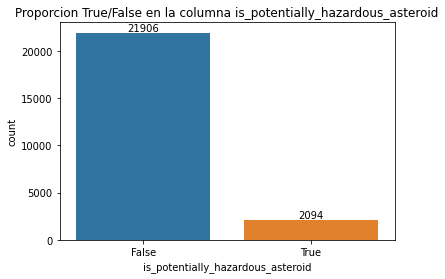

In [18]:
# is_potentially_hazardous_asteroid
ax = sns.countplot(x = df_raw['is_potentially_hazardous_asteroid'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_potentially_hazardous_asteroid')
plt.show()

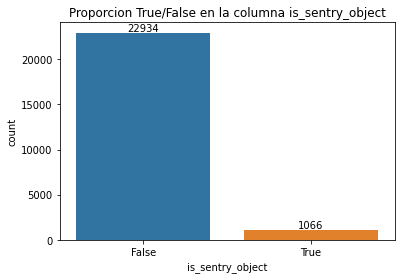

In [19]:
# is_sentry_object
ax = sns.countplot(x = df_raw['is_sentry_object'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_sentry_object')
plt.show()

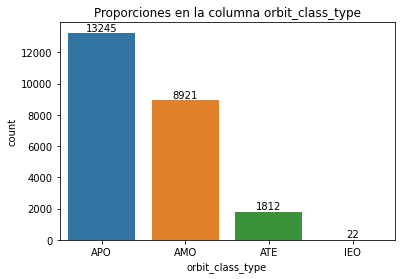

In [20]:
ax = sns.countplot(x = df_raw['orbit_class_type'])
ax.bar_label(ax.containers[0])
plt.title('Proporciones en la columna orbit_class_type')
plt.show()

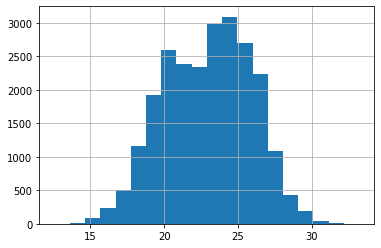

In [48]:
# absolute_magnitude_h

df_raw['absolute_magnitude_h'].hist(bins = 20)
plt.show()

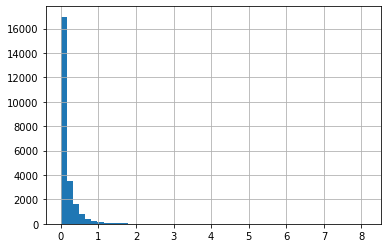

In [26]:
# kilometers_estimated_diameter_min

df_raw['kilometers_estimated_diameter_min'].hist(bins=50)
plt.show()

# El mayor valor registrado es 8.1013048824

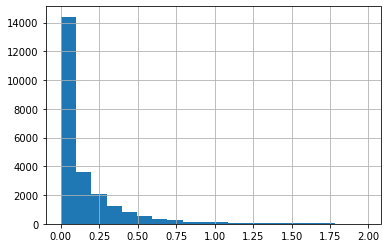

In [47]:
df_raw[df_raw['kilometers_estimated_diameter_min'] < 2]['kilometers_estimated_diameter_min'].hist(bins=20)
plt.show()


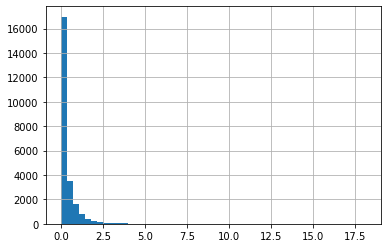

In [28]:
# kilometers_estimated_diameter_max

df_raw['kilometers_estimated_diameter_max'].hist(bins=50)
plt.show()

# El mayor valor registrado es 

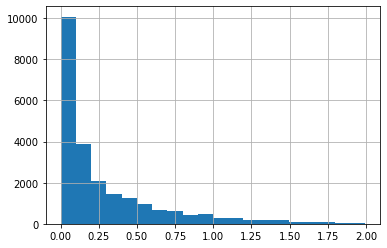

In [46]:
df_raw[df_raw['kilometers_estimated_diameter_max'] < 2]['kilometers_estimated_diameter_max'].hist(bins=20)
plt.show()


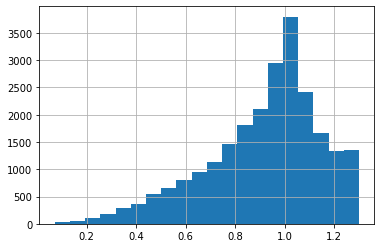

In [33]:
# perihelion_distance

df_raw['perihelion_distance'].hist(bins=20)
plt.show()

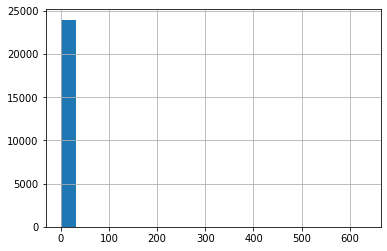

In [34]:
# aphelion_distance

df_raw['aphelion_distance'].hist(bins=20)
plt.show()

# El vmayor valor registrado es 631.8954563363584

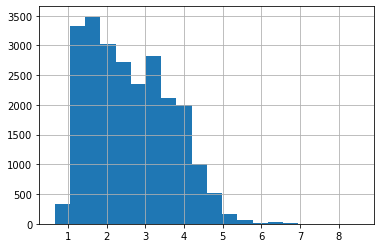

In [41]:
df_raw[df_raw['aphelion_distance'] < 10]['aphelion_distance'].hist(bins=20)
plt.show()


#### Transformacion de datos

- Vamos a convertir a datatime dtype a las columnas 'first_observation_date' y 'last_observation_date'
- Las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object' se encodean en 0 y 1
- La columna 'orbit_class_type' puede encodearse en 0, 1, 2 y 3 por tener 4 categorias diferentes
- La columnas 'orbit_id' podrian pasarse a tipo numerico, verificarlo
- Hay columnas que tienen datos faltantes, analizar situacion

In [ ]:
# Hay un valor en la columna 'first_observation_date' que vale '2008-??-??', por lo cual
# no es posible convertirlo a datetime tipo de dato. Entonces procedemos a borrar ese registro

In [78]:
df_raw = df_raw.drop(df_raw[df_raw['first_observation_date'] == '2008-??-??'].index[0])

In [59]:
# Transformando a datetime tipo de dato

df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date'])
df_raw['last_observation_date'] = pd.to_datetime(df_raw['last_observation_date'])

In [84]:
# Transformacion a 0 y 1 de las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object'

df_raw['is_potentially_hazardous_asteroid'] = pd.Categorical(df_raw['is_potentially_hazardous_asteroid'])
df_raw['is_potentially_hazardous_asteroid'] = df_raw['is_potentially_hazardous_asteroid'].cat.codes

df_raw['is_sentry_object'] = pd.Categorical(df_raw['is_sentry_object'])
df_raw['is_sentry_object'] = df_raw['is_sentry_object'].cat.codes

In [87]:
# Transformando las categorias de 'orbit_class_type' a 0, 1, 2 y 3

df_raw['orbit_class_type'] = pd.Categorical(df_raw['orbit_class_type'])
df_raw['orbit_class_type'] = df_raw['orbit_class_type'].cat.codes

In [102]:
# Verificando valores de la columna 'orbit_id'

df_raw['orbit_id'].sample(10)

11911     5
20220     2
1040     54
17800     2
8284     16
4930     10
20693    10
5576      9
572      33
20674    18
Name: orbit_id, dtype: object

In [104]:
# df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id']) - Unable to parse string "E2021-CI3" at position 10055

# Hay un valor que no es del todo numerico, analizarlo

In [108]:
df_raw[df_raw['orbit_id'] == 'E2021-CI3']

# Solo hay un valor con este id de orbita, se procede a eliminarse

df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'E2021-CI3'].index[0])

In [112]:
# df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id']) - Unable to parse string "MPO392510" at position 14812

In [111]:
df_raw[df_raw['orbit_id'] == 'MPO392510']

# Solo hay un valor con este id de orbita, se procede a eliminarse

df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'MPO392510'].index[0])

In [113]:
df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id'])

# Ahora si funciono, solo eran esos dos valores que contenian letras

In [117]:
# Terminar de transformar a cateorica las columnas 'name' y 'orbit_class_description'

df_raw['name'] = pd.Categorical(df_raw['name'])
df_raw['orbit_class_description'] = pd.Categorical(df_raw['orbit_class_description'])

In [118]:
df_raw.info()

# Las columnas 'absolute_magnitude_h', 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan valores faltantes
# Se procede a llenarlos con las mediana de su columna correspondiente

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23997 entries, 0 to 23999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 23997 non-null  int64         
 1   name                               23997 non-null  category      
 2   absolute_magnitude_h               23989 non-null  float64       
 3   is_potentially_hazardous_asteroid  23997 non-null  int8          
 4   is_sentry_object                   23997 non-null  int8          
 5   kilometers_estimated_diameter_min  23989 non-null  float64       
 6   kilometers_estimated_diameter_max  23989 non-null  float64       
 7   orbit_id                           23997 non-null  int64         
 8   orbit_class_type                   23997 non-null  int8          
 9   perihelion_distance                23997 non-null  float64       
 10  aphelion_distance                 

In [ ]:
imputer_median1 = SimpleImputer(strategy='median', missing_values=np.nan)
imputer_median1 = imputer_median1.fit(X_train[['Age']])
X_train['Age'] = imputer_mean.transform(X_train[['Age']])

In [ ]:
# df_wo_desc = df_drop(columns = ['orbit_class_description'])

In [13]:
# Para el resampling, lo saque del code de decision tree

# df_majority = df[(df["Outcome"]==0)]
# df_minority = df[(df["Outcome"]==1)]
# df_minority_upsampled = resample(df_minority,replace=True,n_samples=400,random_state=42)
# df = pd.concat([df_minority_upsampled,df_majority])
# df["Outcome"].value_counts()